# __Impact of Release Month on Indie Games(PC)__
#### Noah Eddleman


### __Introduction to the Problem__
The creation of a video game is a massive undertaking. Even moreso when the development team consists of few members. The last thing a team wants to do is create a great game and release at the wrong time. While there are many factors relating to the success of a video game, 
i.e. marketing, overall funding. The time of release also plays a role in its exposure to consumers.

### __The Data__
The dataset was obtained on Kaggle from the following link:
https://www.kaggle.com/datasets/artermiloff/steam-games-dataset?select=games_may2024_cleaned.csv

It contains a recently updated database of video games on the PC platform Steam. The data was already cleaned of duplicates and playtest/beta versions of games.

In [942]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [943]:
steam_df: pd.DataFrame = pd.read_csv('games_may2024_cleaned.csv') ## General data

In [944]:
steam_df['release_year'] = steam_df['release_date'].apply(lambda y: int((str(y).split('-'))[0]))
steam_df['release_month'] = steam_df['release_date'].apply(lambda m: int((str(m).split('-'))[1]))
steam_df['release_day'] = steam_df['release_date'].apply(lambda d: int((str(d).split('-'))[2]))

#steam_df['release_date'] = steam_df['release_date'].apply(lambda t: dt.datetime.strptime(t,'%Y-%m-%d')) 
steam_df['release_date'] = pd.to_datetime(steam_df['release_date'], format='%Y-%m-%d')

# Filter by peak player count to remove games that release below player threshold
steam_df = steam_df[steam_df['peak_ccu'] >= 100]

# Get ratio of positive ratings to negative ratings...making sure we don't divide by zero
steam_df['ratio'] = steam_df['positive'] / steam_df['negative'].replace(0, np.nan)

# Get current age of game
steam_df["current_age"] = dt.datetime.now() - steam_df['release_date']


## List of well known AAA publishers/developers within the data

AAA_list = ['VALVE', 'Valve' ,'CD PROJEKT RED',
    'FromSoftware Inc.', 'FromSoftware', 'Bandai Namco Entertainment', 'Rockstar Games', 'Xbox Game Studios',
    'Electronic Arts', 'EA', 'Warner Bros. Games', '2K', 'Bethesda Softworks', 'Larian Studios', 'Ubisoft', 'CAPCOM Co. Ltd.',
    'PlayStation PC LLC', 'CAPCOM Co.', 'SEGA', 'Warner Bros. Interactive Entertainment', 'Paradox Interactive', 'Square Enix',
    'KONAMI', 'Capcom', 'BANDAI NAMCO Entertainment', 'Lucasfilm', 'LucasArts', 'Disney', 'Activision', 'Focus Entertainement', 'Bungie',
    'Activision (Excluding Japan and Asia)', 'FromSoftware (Japan)', 'bandai namco entertainment inc.'
]

probably_indie = []

# adjusting string data
adjusted_publishers = []
for p in steam_df['publishers']:
    for c in "'[]":
        p = p.replace(c, '')
        p = p.lower()
    adjusted_publishers.append(p)

steam_df['publishers'] = adjusted_publishers

# adjusting string data
adjusted_AAA_list = [s.lower() for s in AAA_list]

# add games with publishers not in the AAA list
for p in adjusted_publishers:
    if p not in adjusted_AAA_list:
        probably_indie.append(p)

# If the publisher is in the indie list, set true
steam_df['is_indie'] = steam_df['publishers'].isin(probably_indie)

In [945]:
# Sort the games based on their ratio
games_sorted_by_ratio = steam_df.sort_values(by='ratio', ascending=False)

median_index = int(len(games_sorted_by_ratio) / 2.0)

median_game = games_sorted_by_ratio.iloc[median_index]

# Get median ratio value 
median_ratio = median_game['ratio']
 
# Ratio represents the overall rating of the game, 
# a game with a higher ratio means any given number is the number of times greater the number of positive ratings than negative ratings


# Overall number of indie games
num_indie_games = len(steam_df[steam_df['is_indie'] == True])

num_AAA_games = len(steam_df[steam_df['is_indie'] == False])

indie_to_AAA_ratio = num_indie_games / num_AAA_games


# Only use games that have greater than 50 recommendations
steam_df = steam_df[steam_df['recommendations'] > 50]



In [946]:
# Get ratios from median to 60.0(upper limit)
steam_df = steam_df[(steam_df['ratio'] >= median_ratio - 2.0) & (steam_df['ratio'] <= 60.0)]

# Remove major outliers from median playtime forever
steam_df = steam_df[(steam_df['median_playtime_forever'] < 1_000)]

# Remove major outliers from average playtime forever
steam_df = steam_df[(steam_df['average_playtime_forever'] < 3_000)]

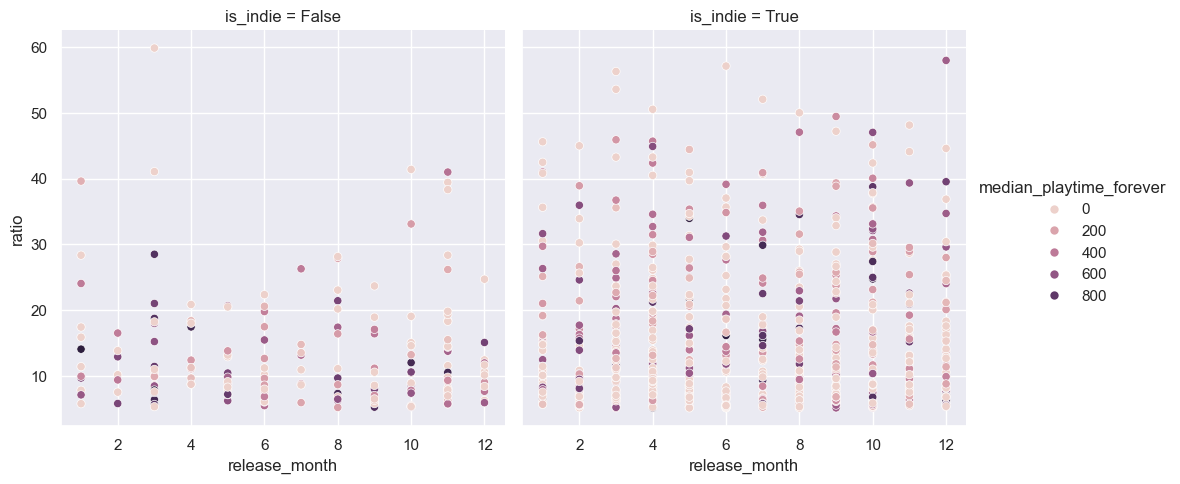

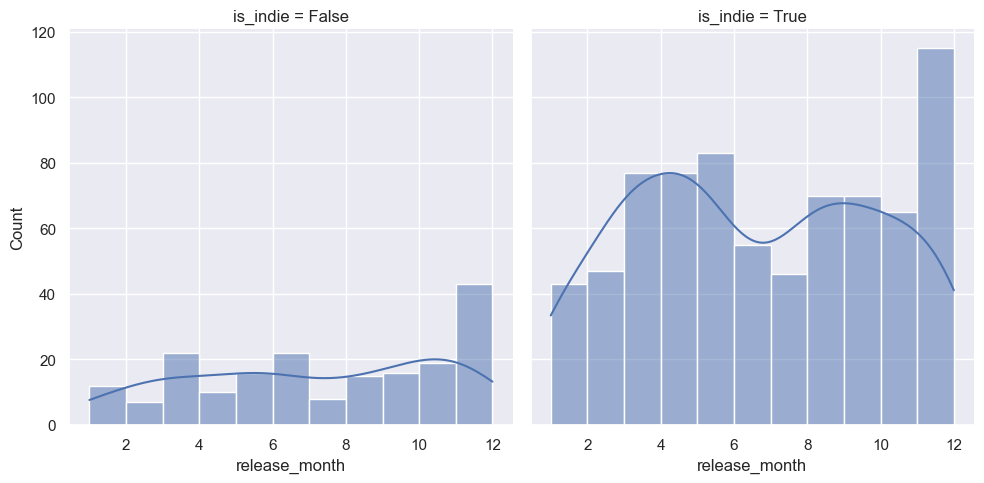

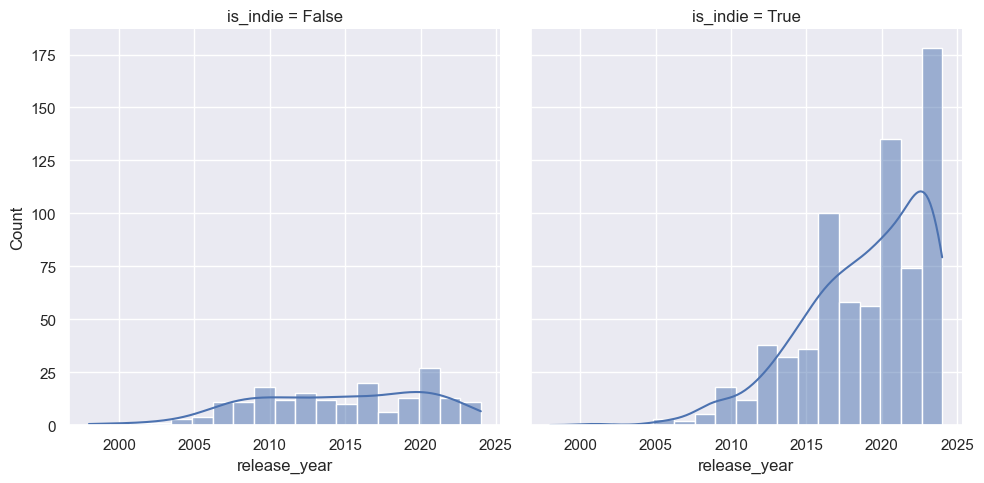

In [951]:

sns.set(rc={"figure.figsize":(20,12)}) 
g = sns.relplot(
    data=steam_df, kind='scatter', col='is_indie',
    x='release_month', y='ratio', 
    hue='median_playtime_forever'
)

sns.displot(data=steam_df, x="release_month", col='is_indie', kde=True)

sns.displot(data=steam_df, x="release_year", col='is_indie', kde=True)


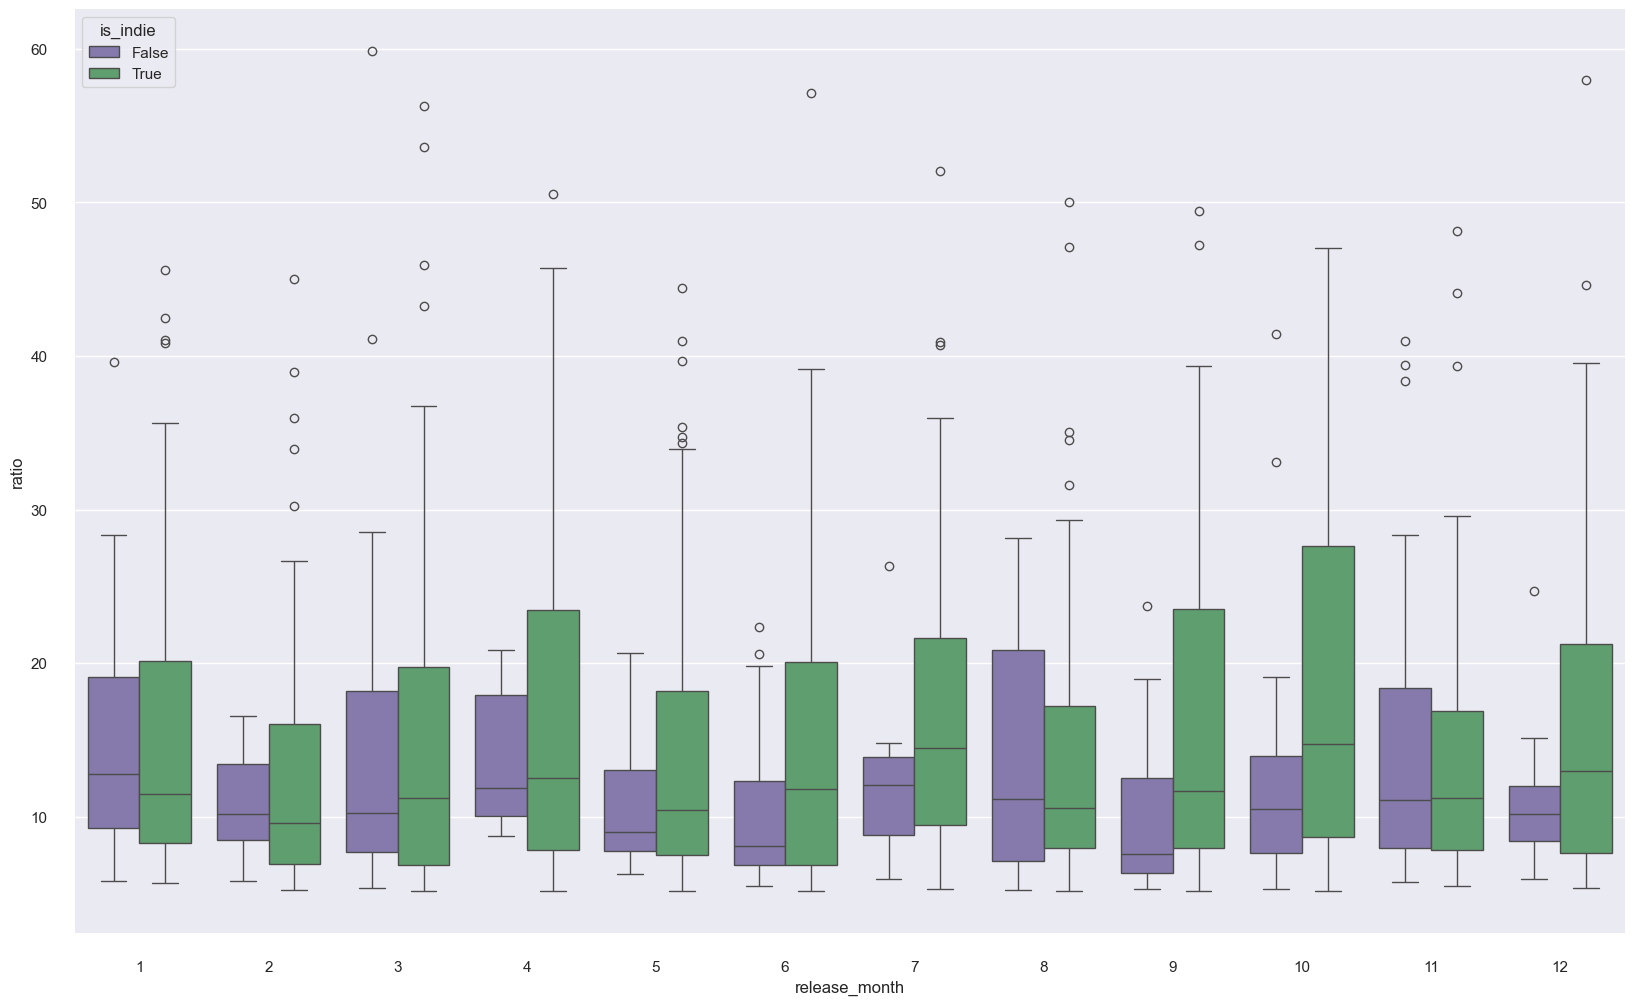

In [948]:

sns.boxplot(x="release_month", y="ratio",
            hue="is_indie", palette=["m", "g"],
            data=steam_df)
sns.despine(offset=10, trim=True)

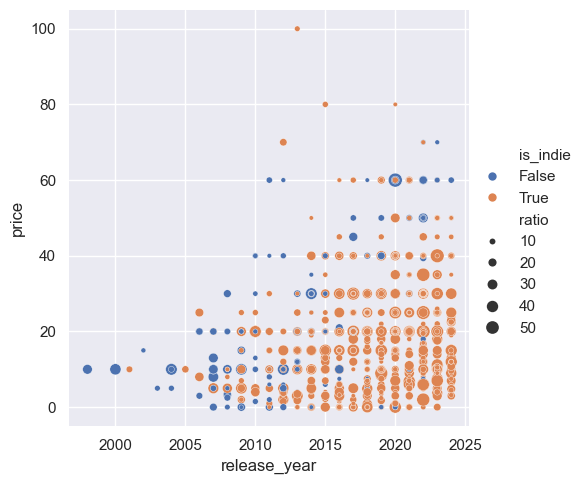

In [949]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=steam_df,
    x="release_year", y="price",
    hue="is_indie", size="ratio", 
    sizes=(10, 100),
)
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)

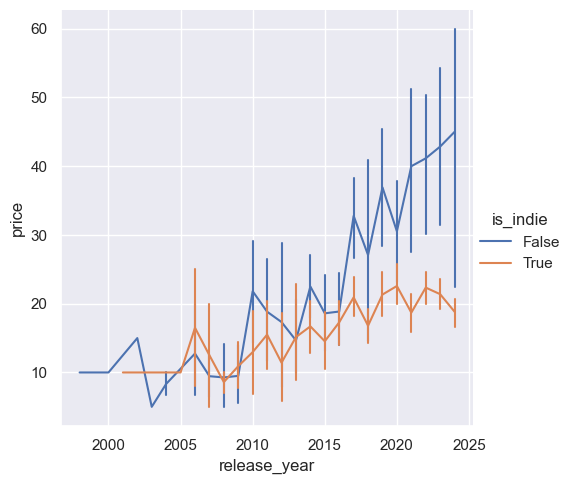

In [950]:
sns.relplot(x='release_year', y='price', data=steam_df, kind="line", hue='is_indie', errorbar=('ci', 90), err_style='bars')